## generate data

In [3]:
import os
import glob
import ast
import json
import pandas as pd

# — CONFIGURATION —
input_dir  = "/n/home04/amuppidi/reasoning-scheduling/data/gsm8k_results_with_difficulty"
output_file = "/n/home04/amuppidi/reasoning-scheduling/data/batch_classify_difficulty.jsonl"
model_name  = "o4-mini"

# Define the JSON Schema for the structured response
response_schema = {
    "type": "object",
    "properties": {
        "difficulty": {
            "type": "string",
            "enum": ["easy", "medium", "hard"]
        },
        "reasoning": {
            "type": "string"
        }
    },
    "required": ["difficulty", "reasoning"],
    "additionalProperties": False
}

# Helper to build one batch request entry
def make_request_entry(custom_id: str, question: str) -> dict:
    prompt = (
        "You are a 8th grade math tutor. Classify the following math question from GSM8k dataset into a difficulty level: "
        "easy, medium, or hard.\n"
        "Respond strictly in JSON format with two keys:\n"
        "- \"difficulty\": one of \"easy\", \"medium\", or \"hard\".\n"
        "- \"reasoning\": a brief explanation (1–2 sentences) for your choice.\n\n"
        f"Question: \"\"\"{question}\"\"\""
    )
    return {
        "custom_id": custom_id,
        "method": "POST",
        "url": "/v1/chat/completions",
        "body": {
            "model": model_name,
            "messages": [
                {"role": "system", "content": "You are a helpful assistant."},
                {"role": "user",   "content": prompt}
            ],
            "response_format": {
                "type": "json_schema",
                "json_schema": response_schema,
                "strict": True
            }
        }
    }

# Open output file for writing
with open(output_file, "w") as fout:
    # Find all train files in the directory
    pattern = os.path.join(input_dir, "*_train_*_with_difficulty.csv")
    for filepath in glob.glob(pattern):
        df = pd.read_csv(filepath)
        filename = os.path.splitext(os.path.basename(filepath))[0]
        # For each question in the CSV, emit one line in the .jsonl
        for _, row in df.iterrows():
            qid = row["question_id"]
            question = row["question_text"]
            custom_id = f"{filename}-{qid}"
            entry = make_request_entry(custom_id, question)
            fout.write(json.dumps(entry) + "\n")

print(f"Wrote batch file with classification requests to {output_file}")


Wrote batch file with classification requests to /n/home04/amuppidi/reasoning-scheduling/data/batch_classify_difficulty.jsonl


In [8]:
import os
import glob
import json
import pandas as pd
from tqdm.notebook import tqdm
from openai import OpenAI
import time

client = OpenAI(
    organization="org-EcCYyn0M7gsIniHsEQURazFb",
    api_key=os.getenv("OPENAI_API_KEY")
)


def classify_question(question: str) -> dict:
    prompt = (
        "You are a math tutor. Classify the following math question into a difficulty level: "
        "easy, medium, or hard.\n"
        "Respond strictly in JSON format with two keys:\n"
        "- \"difficulty\": one of \"easy\", \"medium\", or \"hard\".\n"
        "- \"reasoning\": a brief explanation (1-2 sentences) for your choice.\n\n"
        f"Question: \"\"\"{question}\"\"\""
    )
    resp = client.chat.completions.create(
        model="o4-mini",
        messages=[
            {"role": "system", "content": "You are a helpful assistant."},
            {"role": "user",   "content": prompt}
        ]
    )
    content = resp.choices[0].message.content.strip()
    try:
        return json.loads(content)
    except json.JSONDecodeError:
        return {"error": content}

# --- PROCESS TRAIN FILES ---
input_dir = "/n/home04/amuppidi/reasoning-scheduling/data/gsm8k_results_with_difficulty"
pattern   = "*_train_*_with_difficulty.csv"

for filepath in tqdm(glob.glob(os.path.join(input_dir, pattern)), desc="Train files"):
    df = pd.read_csv(filepath)
    
    # Ensure the gpt_assessment column exists
    if "gpt_assessment" not in df.columns:
        df["gpt_assessment"] = None

    # Identify rows needing assessment
    to_process = df["gpt_assessment"].isna()
    if not to_process.any():
        continue

    # Loop over rows
    for idx in tqdm(df[to_process].index, desc=os.path.basename(filepath)):
        question = df.at[idx, "question_text"]
        assessment = classify_question(question)
        df.at[idx, "gpt_assessment"] = json.dumps(assessment)
    
    # Save back to the same file (or change filename if you prefer)
    df.to_csv(filepath, index=False)


Train files:   0%|          | 0/75 [00:00<?, ?it/s]

gsm8k_Y_train_42_with_difficulty.csv:   0%|          | 0/77 [00:00<?, ?it/s]

gsm8k_Y_train_60_with_difficulty.csv:   0%|          | 0/100 [00:00<?, ?it/s]

gsm8k_Y_train_37_with_difficulty.csv:   0%|          | 0/100 [00:00<?, ?it/s]

gsm8k_Y_train_51_with_difficulty.csv:   0%|          | 0/100 [00:00<?, ?it/s]

gsm8k_Y_train_55_with_difficulty.csv:   0%|          | 0/100 [00:00<?, ?it/s]

gsm8k_Y_train_13_with_difficulty.csv:   0%|          | 0/100 [00:00<?, ?it/s]

gsm8k_Y_train_63_with_difficulty.csv:   0%|          | 0/100 [00:00<?, ?it/s]

gsm8k_Y_train_58_with_difficulty.csv:   0%|          | 0/100 [00:00<?, ?it/s]

gsm8k_Y_train_41_with_difficulty.csv:   0%|          | 0/100 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
# gsm8k,train_4255,"<｜User｜>Jeannie hikes the 12 miles to Mount Overlook at a pace of 4 miles per hour, and then returns at a pace of 6 miles per hour. How long did her hike take, in hours?<｜Assistant｜>",train,"[0.0, 0.02, 0.08, 0.01, 0.0, 0.0, 0.04, 0.07, 0.08, 0.17, 0.13, 0.15, 0.19, 0.14, 0.09, 0.12]",hard,"{""difficulty"": ""easy"", ""reasoning"": ""This problem involves straightforward distance\u00f7rate calculations with simple arithmetic, appropriate for an easy level.""}"


Total questions: 7450
Min tokens: 24
25th percentile: 55.0
Median tokens: 66.0
75th percentile: 81.0
Max tokens: 222
Mean tokens: 70.30429530201343


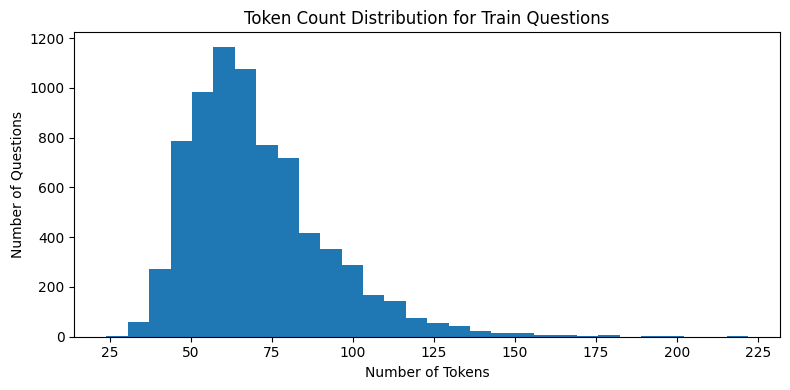

In [6]:
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tiktoken

# — CONFIG —
# Point this at your processed train-with-difficulty CSVs (or raw train CSVs if you prefer)
input_dir = "/n/home04/amuppidi/reasoning-scheduling/data/gsm8k_results_with_difficulty"
pattern   = "*_train_*_with_difficulty.csv"

# 1) Gather all train files
files = glob.glob(os.path.join(input_dir, pattern))

# 2) Initialize tokenizer for your model (e.g. o4-mini uses cl100k_base)
enc = tiktoken.get_encoding("cl100k_base")

# 3) Tokenize every question and record the lengths
token_counts = []
for path in files:
    df = pd.read_csv(path)
    for q in df["question_text"]:
        token_counts.append(len(enc.encode(q)))

# 4) Compute summary statistics
token_counts = np.array(token_counts)
print("Total questions:",       token_counts.size)
print("Min tokens:",           token_counts.min())
print("25th percentile:",      np.percentile(token_counts, 25))
print("Median tokens:",        np.median(token_counts))
print("75th percentile:",      np.percentile(token_counts, 75))
print("Max tokens:",           token_counts.max())
print("Mean tokens:",          token_counts.mean())

# 5) (Optional) Plot the distribution
plt.figure(figsize=(8, 4))
plt.hist(token_counts, bins=30)
plt.title("Token Count Distribution for Train Questions")
plt.xlabel("Number of Tokens")
plt.ylabel("Number of Questions")
plt.tight_layout()
plt.show()


In [7]:
import os
import glob
import pandas as pd
import tiktoken

# Configuration
input_dir = "/n/home04/amuppidi/reasoning-scheduling/data/gsm8k_results_with_difficulty"
pattern   = "*_train_*_with_difficulty.csv"

# Initialize tokenizer for your model
enc = tiktoken.get_encoding("cl100k_base")  # or use the encoding matching your model

total_tokens = 0
# Loop through all train files and accumulate token counts
for path in glob.glob(os.path.join(input_dir, pattern)):
    df = pd.read_csv(path)
    for question in df["question_text"]:
        total_tokens += len(enc.encode(question))

print("Total tokens across all train questions:", total_tokens)


Total tokens across all train questions: 523767


In [5]:
# 4) Poll until complete
while True:
    status = client.batches.retrieve(batch_id)
    print("Status:", status.status)
    if status.status == "completed":
        break
    if status.status in ("failed", "cancelled", "expired"):
        raise RuntimeError(f"Batch did not complete: {status.status}")
    time.sleep(60)  # wait a minute before checking again

# 5) Download the output JSONL
output_file_id = status.output_file_id
content = client.files.content(output_file_id)  # this returns bytes
with open("batch_output.jsonl", "wb") as f:
    f.write(content)
print("Wrote results to batch_output.jsonl")


Status: in_progress
Status: in_progress
Status: cancelling


KeyboardInterrupt: 